In [242]:
import pandas as pd
data_1 = pd.read_excel('Rice_Cammeo_Osmancik.xlsx')
quant_cols_1 = data_1.drop('Class', axis=1)
type_rice_1 = data_1['Class']

In [243]:
import numpy as np
from sklearn.model_selection import train_test_split
x_cols = data_1.columns[:(len(data_1.columns)-1)]
x_train, x_test, y_train, y_test = train_test_split(quant_cols_1, type_rice_1, test_size=0.2)

In [244]:
x_train.iloc[:,0:-1] = x_train.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
x_test.iloc[:,0:-1] = x_test.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [245]:
from sklearn import decomposition
# trained points
pca = decomposition.PCA(n_components=2)
test_reduced = pca.fit_transform(x_train[x_cols])
pc0_trained = test_reduced[:, 0]
pc1_trained = test_reduced[:, 1]

In [246]:
# test points
test_data_reduced = pca.transform(x_test[x_cols])
pc0_test = test_data_reduced[:, 0]
pc1_test = test_data_reduced[:, 1]

In [247]:
pca_train = pd.DataFrame({'pc0':pc0_trained, 'pc1':pc1_trained,'type_rice': y_train}) 
pca_train.to_csv('pca_train.csv') 
pca_train = pd.read_csv('pca_train.csv')
pc0 = pca_train["pc0"]
pc1 = pca_train["pc1"]
type_rice = pca_train['type_rice']
c_0 = []
c_1 = []
o_0 = []
o_1 = []

for i in range (len(type_rice)):
    if type_rice[i] == 'Cammeo':
        c_0.append(pc0[i])
        c_1.append(pc1[i])
    if type_rice[i] == 'Osmancik':
        o_0.append(pc0[i])
        o_1.append(pc1[i])

pca_test = pd.DataFrame({'pc0':pc0_test, 'pc1':pc1_test,'type_rice': y_test})  
pc0_test = pca_test["pc0"]
pc1_test = pca_test["pc1"]
type_rice_test = pca_test['type_rice']

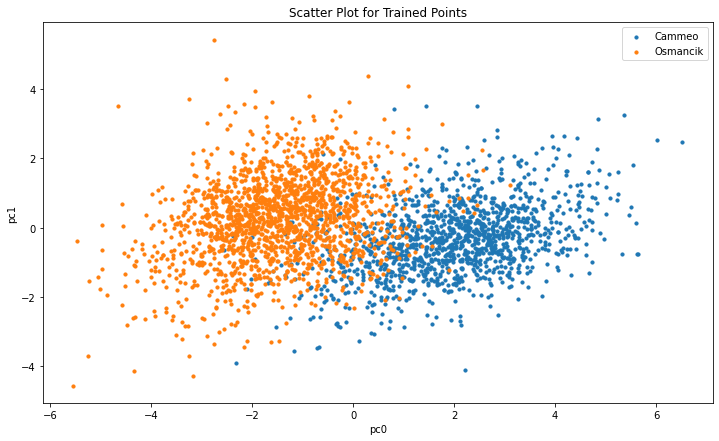

In [248]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,7))
plt.scatter(c_0, c_1, label = 'Cammeo', s = 10)
plt.scatter(o_0, o_1, label = 'Osmancik', s = 10)
plt.xlabel("pc0")
plt.ylabel("pc1")
plt.legend()
plt.title("Scatter Plot for Trained Points")
plt.show()

In [249]:
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from collections import Counter
import heapq
import numpy as np
import math

In [250]:
class Node():
    def __init__(self, isleaf, xlo, xhi, ylo, yhi, xmid = None, ymid = None, x = None, y = None, classifier = None, ul = None, ur = None, ll = None, lr = None, _parent = None):
        self.nodecount = 0 
        self.isleaf = isleaf 
        self.x = x
        self.y = y 
        self.classifier = classifier 
 
        self.xlo = xlo
        self.xmid = xmid # median     
        self.xhi = xhi
        self.ylo = ylo
        self.ymid = ymid # median      
        self.yhi = yhi
       
        self.ul = ul
        self.ur = ur
        self.ll = ll
        self.lr = lr
        self._parent = _parent


In [251]:
class QdTree():
    def __init__(self, xlo, xhi, ylo, yhi):
        self.root = Node(True, xlo, xhi, ylo, yhi)

    
    def insert_node(self, node, data):
        if len(data)==0:
            return

        elif len(data)==1:
            node.nodecount = 1
            node.isleaf = True
            node.x = data["pc0"].iloc[0]
            node.y = data["pc1"].iloc[0]
            node.classifier=data["type_rice"].iloc[0]
        
        else:
            node.isleaf = False
            node.nodecount = len(data) 
            
            node.xmid = np.median(data["pc0"])
            node.ymid = np.median(data["pc1"])

            ul_data = data[(data["pc0"] < node.xmid) & (data["pc1"] >= node.ymid)]        
            ur_data = data[(data["pc0"] >= node.xmid) & (data["pc1"]>=node.ymid)]
            ll_data = data[(data["pc0"]<node.xmid) & (data["pc1"]<node.ymid)]
            lr_data = data[(data["pc0"]>=node.xmid) & (data["pc1"]<node.ymid)]
        
            node.ul = Node(1,node.xlo,node.xmid,node.ymid,node.yhi,_parent=node)
            self.insert_node(node.ul,ul_data)          
            node.ur = Node(1,node.xmid,node.xhi,node.ymid,node.yhi,_parent=node)
            self.insert_node(node.ur,ur_data)                                
            node.ll = Node(1,node.xlo,node.xmid,node.ylo,node.ymid,_parent=node)            
            self.insert_node(node.ll,ll_data)
            node.lr = Node(1,node.xmid,node.xhi,node.ylo,node.ymid,_parent=node) 
            self.insert_node(node.lr, lr_data)
            
            if not node.ur.nodecount:
                node.ur = None
            if not node.ul.nodecount:
                node.ul = None 
            if not node.ll.nodecount:
                node.ll = None 
            if not node.lr.nodecount:
                node.lr = None 


    def search_node(self, x, y, count = 1):
        root = self.root
        parent = None
        while root and not root.isleaf:
            if root.nodecount <= count:
                return root

            if x < root.xmid and y < root.ymid:
                parent = root
                root = root.ll

            elif x < root.xmid and y >= root.ymid:
                parent = root
                root = root.ul

            elif x >= root.xmid and y < root.ymid:
                parent = root
                root = root.lr

            else:
                parent = root
                root = root.ur

        return root if root else parent
    
    def euclidean_distance(self, x, y):
        dist = (x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2
        return math.sqrt(dist)

    def _within_distance(self, x, y,node,d):
        if x<node.xlo and y<node.ylo:
            return self.euclidean_distance([x,y], [node.xlo,node.ylo])<=d
        elif x<node.xlo and y<node.yhi:
            return self.euclidean_distance([x,y],[node.xlo,y])<=d
        elif x<node.xlo and y>=node.yhi:
            return self.euclidean_distance([x,y],[node.xlo,node.yhi])<=d
        elif x<node.xhi and y<node.ylo:
            return self.euclidean_distance([x,y],[x,node.ylo])<=d
        elif x<node.xhi and y<node.yhi:
            return True
        elif x<node.xhi and y>=node.yhi:
            return self.euclidean_distance([x,y],[x,node.yhi])<=d          
        elif x>=node.xhi and y<node.ylo:
            return self.euclidean_distance([x,y],[node.xhi,node.ylo])<=d
        elif x>=node.xhi and y<node.yhi:
            return self.euclidean_distance([x,y],[node.xhi,node.yhi])<=d
        elif x>=node.xhi and y>=node.yhi:
            return self.euclidean_distance([x,y],[node.xhi,node.yhi])<=d

    def knn(self, x, y, k):
        neighbors = []
        lst = [self.search_node(x,y,count=k)]

        while lst:
            item=lst.pop(0) 
            if item.isleaf:
                euclidean_distance = self.euclidean_distance([item.x, item.y], [x,y])
                heapq.heappush(neighbors,(-euclidean_distance, item))
            else:
                for child in [item.ll,item.lr,item.ul,item.ur]:
                    if child:
                        lst.append(child)                  
        lst=[self.root]
        while lst:
            item=lst.pop(0)
            if item.isleaf:
                euclidean_distance=self.euclidean_distance([item.x, item.y],[x,y])
                heapq.heappush(neighbors,(-euclidean_distance, item))
                if len(neighbors) > k:
                    heapq.heappop(neighbors)
            else:
                for child in [item.ll,item.lr,item.ul,item.ur]: 
                    if child and child != (self.search_node(x,y,count=k)):
                        if len(neighbors)<k or self._within_distance(x,y,child,-neighbors[0][0]):
                            lst.append(child)
        return neighbors

In [252]:
datatree = QdTree(min(pca_train["pc0"]),max(pca_train["pc0"]),min(pca_train["pc1"]),max(pca_train["pc1"]))
datatree.insert_node(datatree.root,pca_train)

In [254]:
result = []
true_prediction = []

for index, data in pca_test.iterrows():
    _tree = datatree.knn(data["pc0"], data["pc1"], 1)
    count = []
    for item in _tree:
        count.append(item[1].classifier)
    qdtree = Counter(count).most_common(1)[0][0]  
    result.append(qdtree)
true_prediction += pca_test['type_rice'].to_list()

print("The confusion matrix of k = 1")
print(confusion_matrix(result,true_prediction))



The confusion matrix of k = 1
[[273  48]
 [ 43 398]]


In [260]:
result = []
true_prediction = []

for index,data in pca_test.iterrows():
    _tree = datatree.knn(data["pc0"],data["pc1"], 5)
    count = []
    for item in _tree:
        count.append(item[1].classifier)
    qdtree = Counter(count).most_common(1)[0][0]  
    result.append(qdtree)
true_prediction += pca_test['type_rice'].to_list()

print("The confusion matrix of k = 5")
print(confusion_matrix(result,true_prediction))

The confusion matrix of k = 5
[[284  35]
 [ 32 411]]


In [261]:
result = []
_tree = datatree.knn(x = 0.123, y = 0.456, k=1)
count = []
for item in _tree:
    count.append(item[1].classifier)
qdtree = Counter(count).most_common(1)[0][0]  
result.append(qdtree)
result

['Osmancik']